In [18]:
import numpy as np 
import cupy as cp
import cupyx as cpx
import time
import cv2

from gpu_acc_utils import *
from cupyx.scipy.interpolate import RegularGridInterpolator as reg_interp

In [2]:
intrinsics = np.array([3040, # number of pixel columns
                       4056, # number of pixel rows
                       1503.0136, # U component of principal point
                       2163.4301, # V component of principal point
                       2330.4972, # U component of focal length
                       2334.0017, # V component of focal length
                       -0.3587, # radial distortion 
                       0.1388, # radial distortion
                       -0.0266, # radial distortion
                       -0.0046, # tangential distortion
                       0.0003 # tangential distortion
                       ])

In [3]:
extrinsics = np.array([712159.597863065, # camera x in world
                       33136.9994153273, # camera y in world
                       3.72446811607855, # camera elev in world
                       1.30039127961854, # azimuth
                       1.02781393967485, # tilt
                       -0.160877893129538 # roll/swing
                       ])

In [4]:
import pandas as pd
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from rectification_utils import *
import open3d as o3d
import laspy
import lazrs
import laszip

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


(3, 35549)
Directory to store grids already exists: data/generated_grids


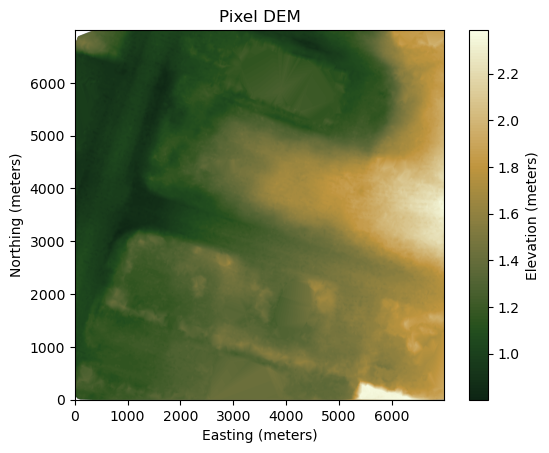

In [5]:
file_path = '/home/rmccune/depth_mapping/data/lidar/Job1051007_34077_04_88.laz'

las = laspy.read(file_path)

pts_mask = las.classification == 2 # land classification (1 is unclassified points)

xyz_t = np.vstack([las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]])

building_xyz_m = xyz_t * 0.3048 

point_cloud_df = pd.DataFrame(building_xyz_m.T, columns=['x', 'y', 'z'])

max_x_extent = 712230
min_x_extent = 712160
max_y_extent = 33170
min_y_extent = 33100

# Filter the DataFrame
filtered_df = point_cloud_df[
    (point_cloud_df['x'] >= min_x_extent) & (point_cloud_df['x'] <= max_x_extent) &
    (point_cloud_df['y'] >= min_y_extent) & (point_cloud_df['y'] <= max_y_extent)
]

x = filtered_df['x'].values
y = filtered_df['y'].values
z = filtered_df['z'].values

resolution = 0.01 # meters

pts_array = np.array([x, y, z])

print(pts_array.shape)

grid_dir = 'data/generated_grids'
grid_x, grid_y, grid_z = gen_grid(min_x_extent, max_x_extent, min_y_extent, max_y_extent, resolution, pts_array, dir=grid_dir)

grid_x = grid_x.T
grid_y = grid_y.T
grid_z = grid_z.T

# Get the topo colormap from cmocean
cmap = cmocean.cm.topo

# Truncate the colormap to get only the above-land portion
# Assuming "above land" is the upper half of the colormap
above_land_cmap = LinearSegmentedColormap.from_list(
    'above_land_cmap', cmap(np.linspace(0.5, 1, 256))
)

plt.imshow(grid_z, origin='lower', cmap=above_land_cmap)
plt.colorbar(label='Elevation (meters)')
plt.title('Pixel DEM')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')

# Save the figure before showing it
# plt.savefig('/home/rmccune/depth_mapping/plots/pixel_DEM_1cm_res_CB_03.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [6]:
from rectification_utils import *

In [7]:
start_time = time.perf_counter()

ir = mergeRectify('CAM_CB_03_20231008174225.jpg', intrinsics, extrinsics, grid_x, grid_y, grid_z)

end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Function execution time: {elapsed_time:.6f} seconds")

/home/rmccune/depth_mapping/rectification_utils.py:243: RuntimeWarning: invalid value encountered in cast
  Ud = Ud.astype(int)
/home/rmccune/depth_mapping/rectification_utils.py:244: RuntimeWarning: invalid value encountered in cast
  Vd = Vd.astype(int)


Function execution time: 12.361042 seconds


/home/rmccune/depth_mapping/rectification_utils.py:247: RuntimeWarning: invalid value encountered in cast
  ir = np.array(ir, dtype=np.uint8)


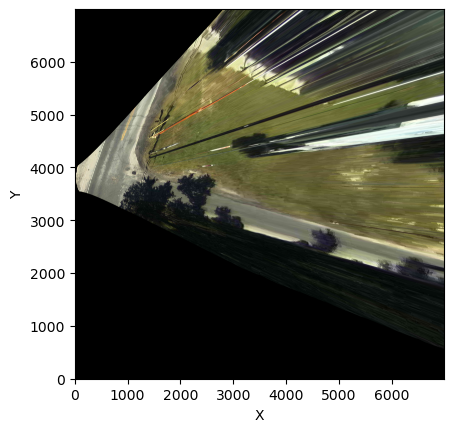

In [8]:
plt.imshow(ir)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [9]:
grid_x_gpu = cp.array(grid_x)
grid_y_gpu = cp.array(grid_y)
grid_z_gpu = cp.array(grid_z)

intrinsics_gpu = cp.array(intrinsics)
extrinsics_gpu = cp.array(extrinsics)

start_time = time.perf_counter()

ir_gpu = mergeRectify_gpu('CAM_CB_03_20231008174225.jpg', intrinsics_gpu, extrinsics_gpu, grid_x_gpu, grid_y_gpu, grid_z_gpu)

end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Function execution time: {elapsed_time:.6f} seconds")

Function execution time: 0.985884 seconds


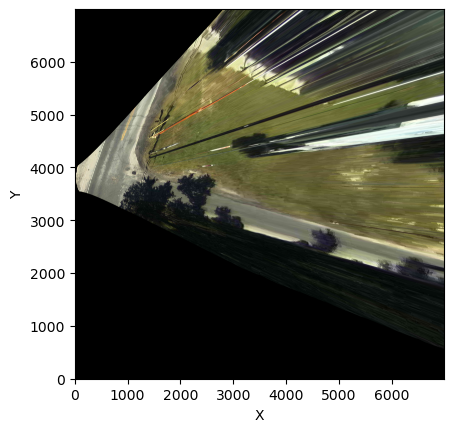

In [10]:
show_ir_gpu = cp.asnumpy(ir_gpu)
plt.imshow(show_ir_gpu)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

In [ ]:
start_time = time.perf_counter()

I = cv2.imread('CAM_CB_03_20231008174225.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Function execution time: {elapsed_time:.6f} seconds")

Function execution time: 0.079098 seconds


In [ ]:
images_folder = '/home/rmccune/depth_mapping/data/CB03_12172023/orig_images'
zarr_store_path = '/home/rmccune/depth_mapping/data/zarr/orig_image_rects'

mergeRectifyFolder_gpu(images_folder, intrinsics, extrinsics, grid_x_gpu, grid_y_gpu, grid_z_gpu, zarr_store_path)

<Group file:///home/rmccune/depth_mapping/zarr/orig_image_rects>

In [24]:
labels_folder = '/home/rmccune/depth_mapping/data/CB03_12172023/labels'
zarr_store_path = '/home/rmccune/depth_mapping/data/zarr/labels_rects'

mergeRectifyLabelsFolder_gpu(labels_folder, intrinsics_gpu, extrinsics_gpu, grid_x_gpu, grid_y_gpu, grid_z_gpu, zarr_store_path)

<Group file:///home/rmccune/depth_mapping/data/zarr/labels_rects>

In [31]:
zarr_store_path = '/home/rmccune/depth_mapping/data/zarr/labels_rects'

img_id = "CAM_CB_03_20231217123625_predseg_labels_rectified"
img_store_path = f"{zarr_store_path}/{img_id}"

# Open the Zarr store
img_store = zarr.open(img_store_path, mode="r")

In [32]:
labels = img_store[:]

np.unique(labels)

array([0, 1, 2, 3, 5], dtype=uint8)

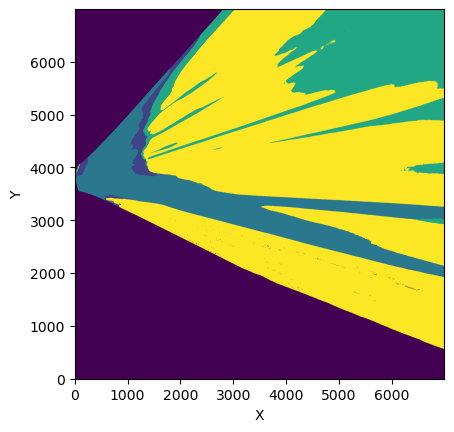

In [33]:
plt.imshow(labels, cmap='viridis')
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

## Depth Mapping